# **Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset (15K Images)**
- **Nama:** Wahyu Damar Iswara
- **Email:** w.damar.iswara@gmail.com
- **ID Dicoding:** M180D5Y1948

## **Import Semua Packages/Library yang Digunakan**

In [ ]:
!pip install pipreqs
!pip install split-folders
!pip install -q tensorflowjs
!pip install wrapt==1.14.1
!pip install session-info

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
# Library umum
import os
import glob
import random
import shutil
import zipfile
import pathlib
import argparse
import kagglehub
import numpy as np
import session_info
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm as tq
from random import sample
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Pemrosesan Citra
import cv2
from PIL import Image, ImageEnhance
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

# Pembanagunan Model
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau
)
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


## **Data Preparation**

### Data Loading

In [ ]:
# Download dataset
cache_dir = "/root/.cache/kagglehub/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images"

# Hapus folder cache kalau ada
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Cache lama dihapus, siap download ulang.")

# Download ulang (saya malas buat folder baru waktu proses, ehee)
path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")
print("Path ke dataset baru:", path)

Path ke dataset baru: /kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images


In [ ]:
# Path asli dataset dari kagglehub
data_folder = "Shoe vs Sandal vs Boot Dataset"
complete_folder = os.path.join(path, data_folder)

# Tujuan salinan dataset
directory = "/content/dataset"

# Copy dataset ke /content
if os.path.exists(directory):
    shutil.rmtree(directory)
shutil.copytree(complete_folder, directory)

print("Dataset berhasil disalin ke:", directory)

Dataset berhasil disalin ke: /content/dataset


In [ ]:
classes = ["Boot", "Sandal", "Shoe"]

filepaths = []
class_labels = []

for cls in classes:
    class_folder = os.path.join(directory, cls)
    for filename in os.listdir(class_folder):
        filepaths.append(os.path.join(class_folder, filename))
        class_labels.append(cls)

# Buat DataFrame utama
df = pd.DataFrame({
    'filename': filepaths,
    'class': class_labels
})

df.head()

,filename,class
0,/content/dataset/Boot/boot (2154).jpg,Boot
1,/content/dataset/Boot/boot (4499).jpg,Boot
2,/content/dataset/Boot/boot (2382).jpg,Boot
3,/content/dataset/Boot/boot (3205).jpg,Boot
4,/content/dataset/Boot/boot (4463).jpg,Boot


In [ ]:
df.describe()

,filename,class
count,15000,15000
unique,15000,3
top,/content/dataset/Shoe/Shoe (687).jpg,Boot
freq,1,5000


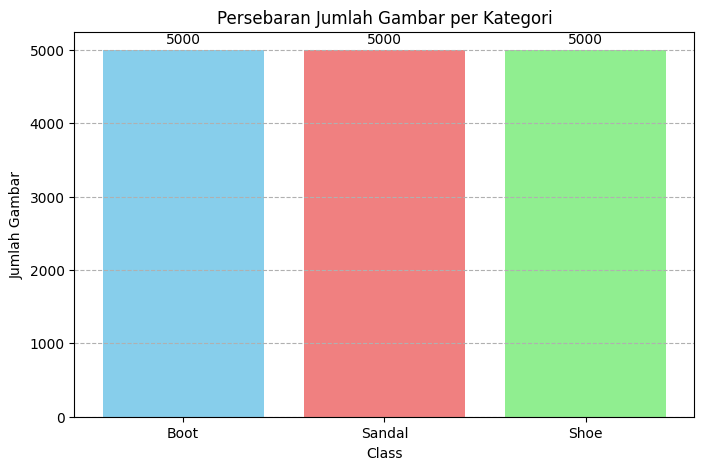

In [ ]:
class_counts = []
for cls in classes:
    class_folder = df.loc[df['class'] == cls, 'filename']
    class_count = len(class_folder)
    class_counts.append((cls, class_count))

# DataFrame untuk menghitung jumlah persebaran data
class_counts_df = pd.DataFrame(class_counts, columns=['Class', 'Count'])

# Buat Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts_df['Class'], class_counts_df['Count'], color=['skyblue', 'lightcoral', 'lightgreen'])

# Menambahkan label nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Persebaran Jumlah Gambar per Kategori')
plt.xlabel('Class')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--')
plt.show()

### Data Preprocessing

In [ ]:
# Fungsi untuk menampilkan gambar
def display_image(path, num_images=5, color='bgr'):
    image_filenames = os.listdir(path)

    # Batas menampilkan gambar
    num_images = min(num_images, len(image_filenames))

    # Buat plot gambar
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='skyblue')

    # Display gambar
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        if (color == 'bgr'):
            axes[i].imshow(image)
        else:
          axes[i].imshow(image, cmap=color)
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

Class: Boot


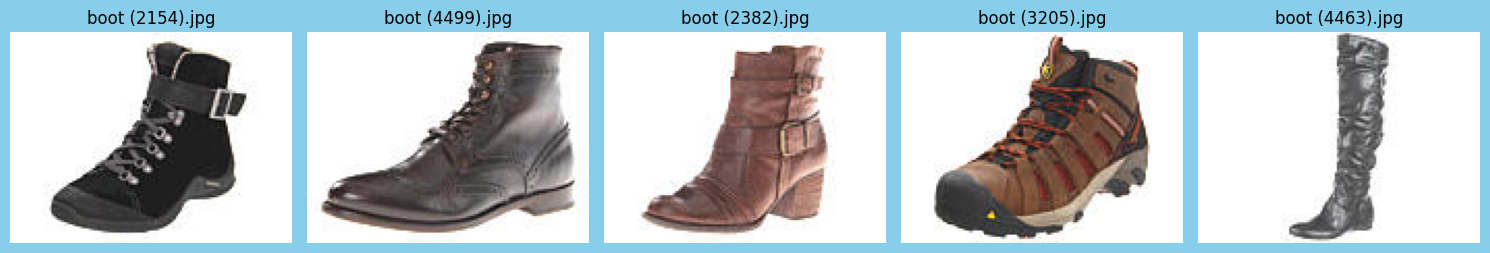

Class: Sandal


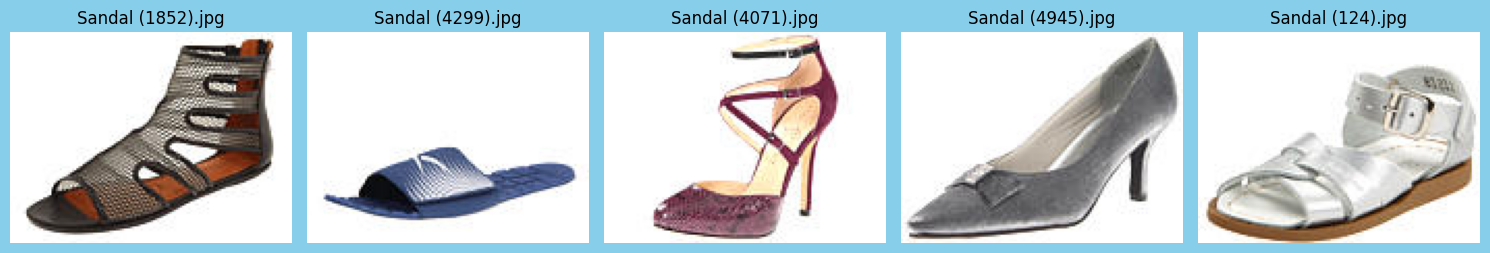

Class: Shoe


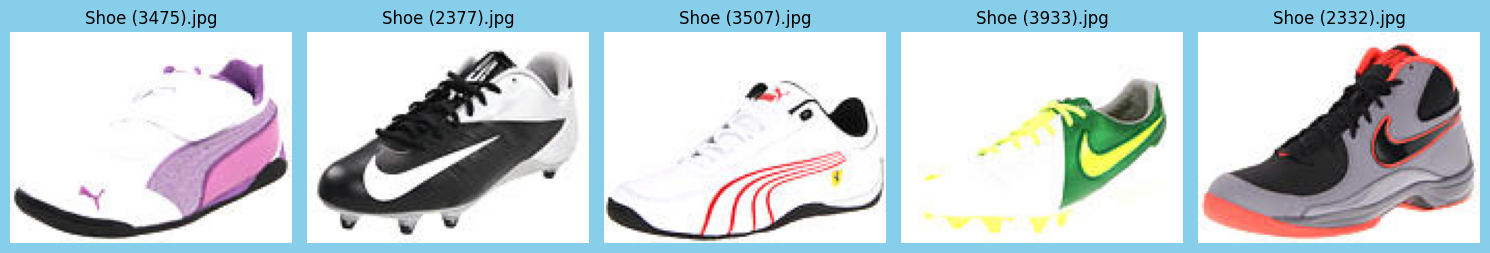

In [ ]:
# Tampilkan 5 gambar untuk tiap kategori
for cls in classes:
    class_path = os.path.join(directory, cls)
    print(f"Class: {cls}")
    display_image(class_path, num_images=5, color='bgr')

#### *Images Enhancement*

In [ ]:
# Naikkan kontras, turunkan brightness dikit agar lebih terlihat
for cls in classes:
  class_path = os.path.join(directory, cls)
  for filename in os.listdir(class_path):
    img_path = os.path.join(class_path, filename)

    img = Image.open(img_path).convert("RGB")

    img = ImageEnhance.Contrast(img).enhance(1.2)
    img = ImageEnhance.Brightness(img).enhance(0.9)

    img = ImageEnhance.Sharpness(img).enhance(1.1)
    img.save(img_path)

Class: Boot


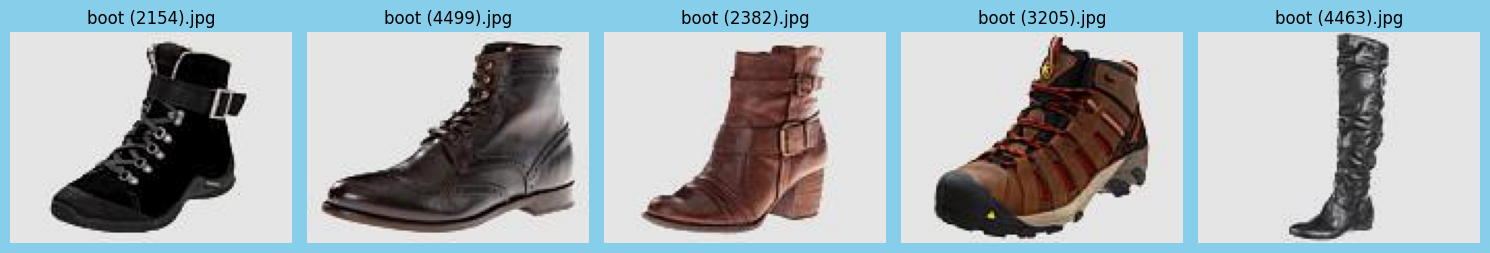

Class: Sandal


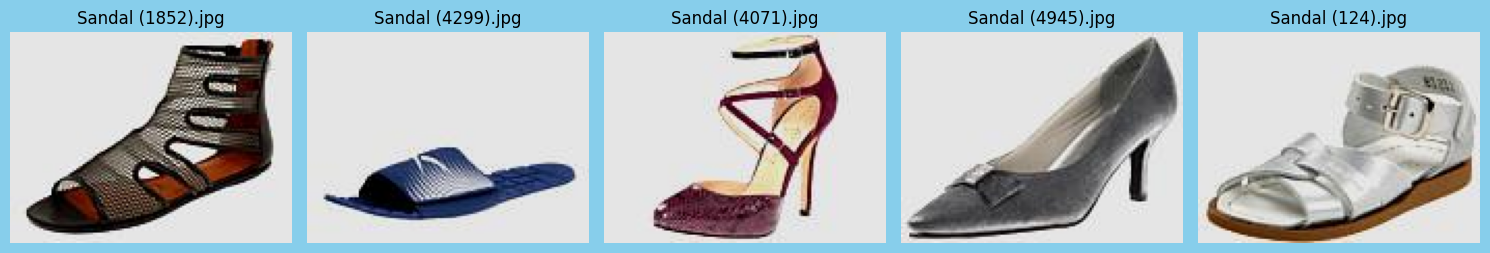

Class: Shoe


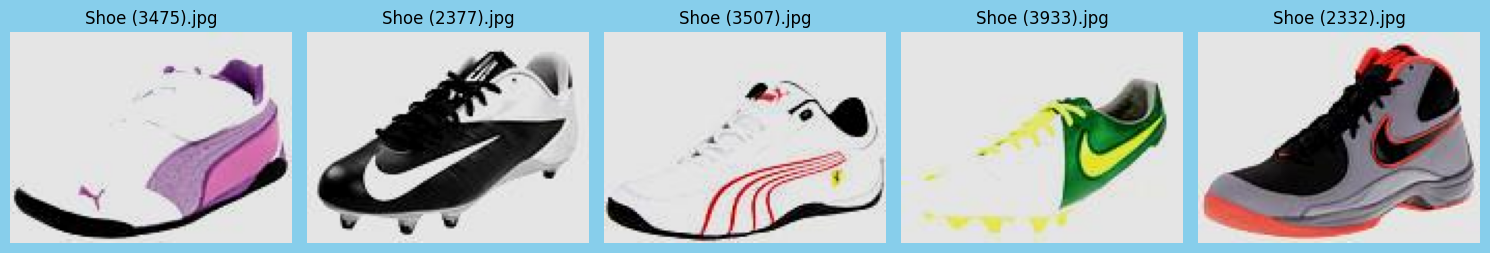

In [ ]:
# Tampilkan 5 gambar untuk tiap kategori (setelah enchancement)
for cls in classes:
    class_path = os.path.join(directory, cls)
    print(f"Class: {cls}")
    display_image(class_path, num_images=5, color='bgr')

#### *Convert Images to Gray*

In [ ]:
# Ubah gambar tiap kategori menjadi grayscale
for cls in classes:
  class_path = os.path.join(directory, cls)
  for image_filename in os.listdir(class_path):
    image_path = os.path.join(class_path, image_filename)
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(image_path, gray_image)

Class: Boot


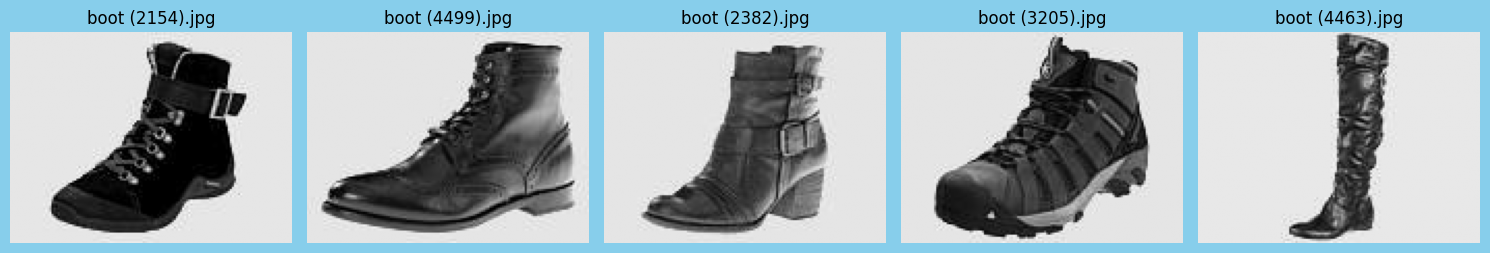

Class: Sandal


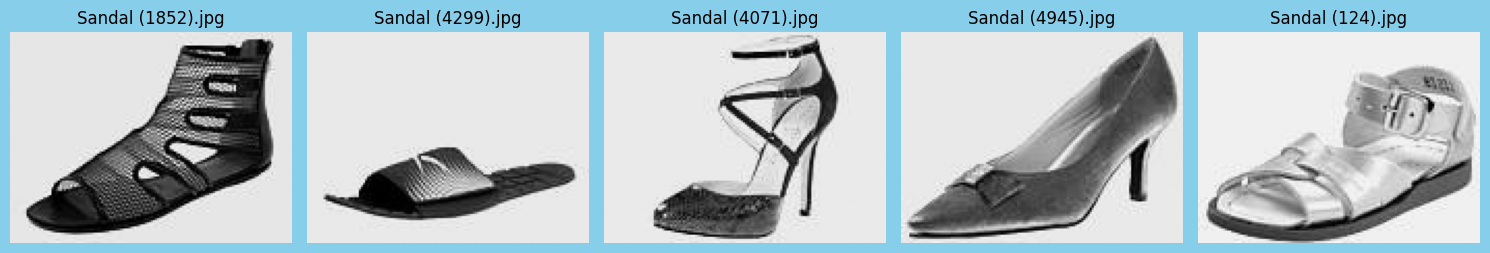

Class: Shoe


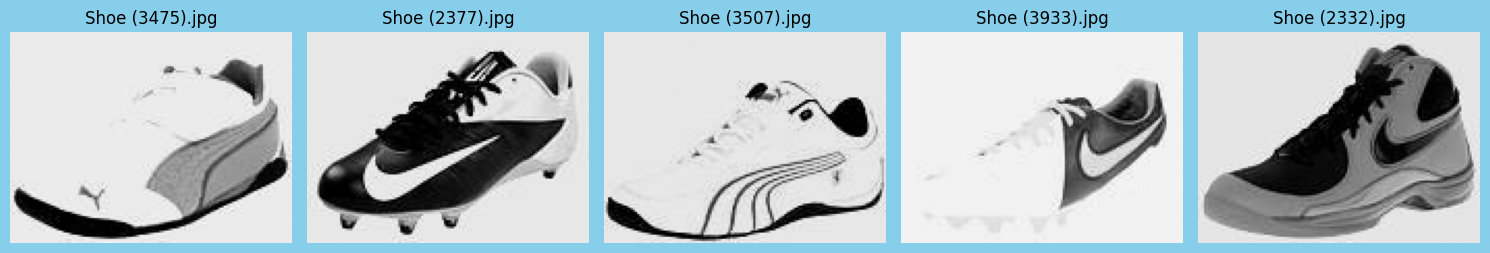

In [ ]:
# Tampilkan gambar hasil grayscale
for cls in classes:
    class_path = os.path.join(directory, cls)
    print(f"Class: {cls}")
    display_image(class_path, num_images=5, color='gray')

#### *Edge Detection*

In [ ]:
# Edge Detection
def process_and_edge(image_path, num_images=5, sigma=0.33):
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (3,3), 0)
  edged = cv2.Canny(blurred, 10, 200)
  return edged

In [ ]:
# Gunakan edge detection pada gambar
for cls in classes:
  class_path = os.path.join(directory, cls)
  for image_filename in os.listdir(class_path):
    image_path = os.path.join(class_path, image_filename)
    edged_image = process_and_edge(image_path)
    cv2.imwrite(image_path, edged_image)

Class: Boot


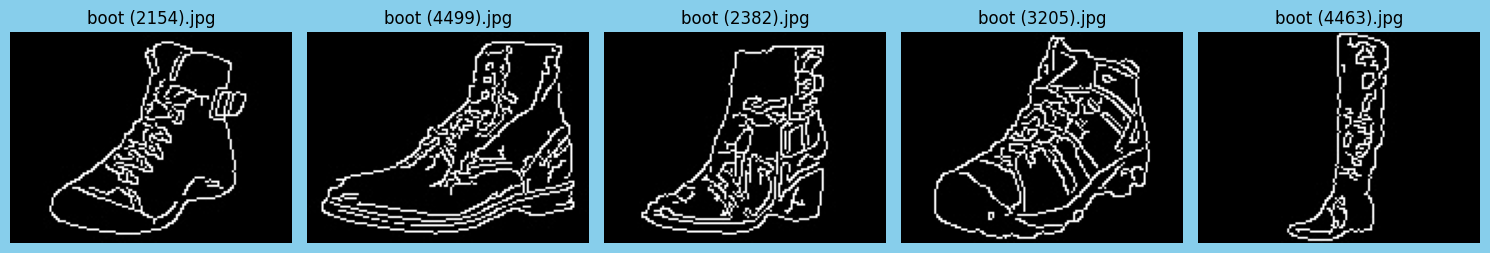

Class: Sandal


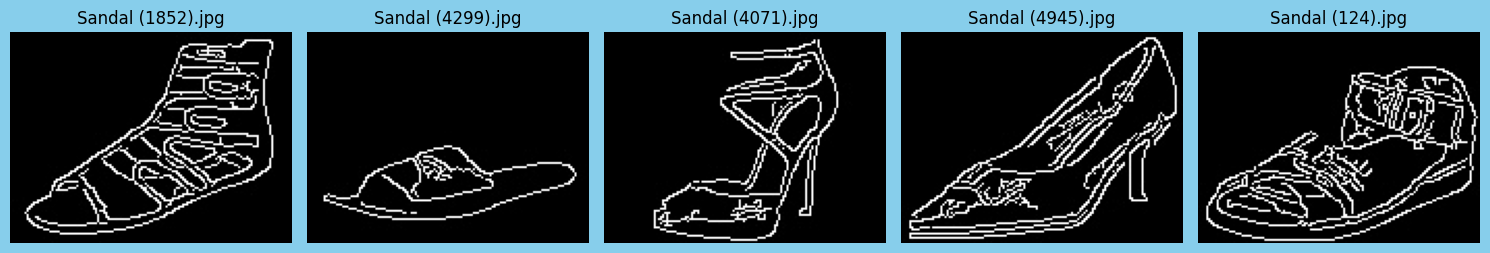

Class: Shoe


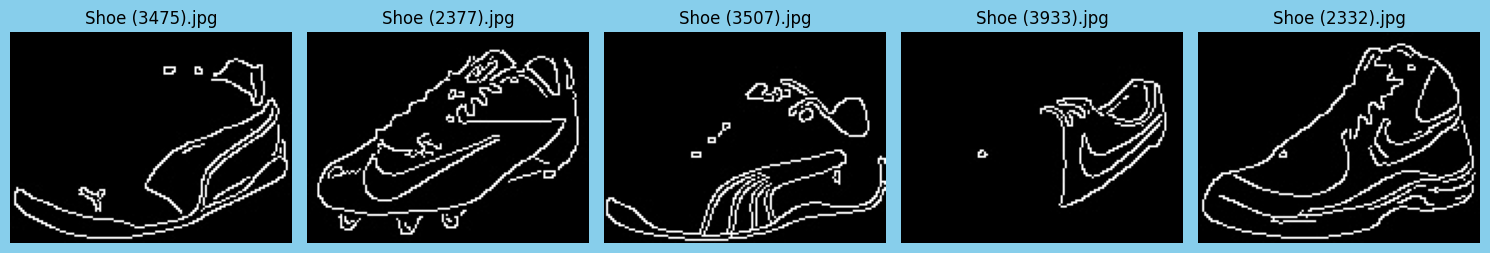

In [ ]:
# Tampilkan hasil edge detection
for cls in classes:
    class_path = os.path.join(directory, cls)
    print(f"Class: {cls}")
    display_image(class_path, num_images=5, color='gray')

#### *Train, Test, Validation Split*

In [ ]:
# Train, test, validation (80:10:10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

In [ ]:
# Cek jumlah data pada train, test, validation
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data test: {len(test_df)}")
print(f"Jumlah data validation: {len(val_df)}")

Jumlah data train: 12000
Jumlah data test: 1500
Jumlah data validation: 1500


## **Modelling**

### Image Generation

In [ ]:
# DatageGenerator untuk train, test, validation
batch_size = 32
image_size = (128, 128)

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
  dataframe=train_df,
  x_col='filename',
  y_col='class',
  target_size=image_size,
  color_mode='grayscale',
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [ ]:
# Print class indices
class_indices_train = train_gen.class_indices
print("Class indices for training generator:", class_indices_train)

Class indices for training generator: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}


### CNN Architecture

In [ ]:
# Modeling CNNN
model = Sequential([
  Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,1)),
  MaxPooling2D(2,2),
  BatchNormalization(),

  Conv2D(64, (3,3), activation='relu', padding='same'),
  MaxPooling2D(2,2),
  BatchNormalization(),
  Dropout(0.3),

  Conv2D(64, (3,3), activation='relu', padding='same'),
  MaxPooling2D(2,2),
  BatchNormalization(),
  Dropout(0.3),

  Flatten(),
  Dense(128, activation='relu', kernel_initializer=HeNormal()),
  Dropout(0.4),
  Dense(3, activation='softmax', kernel_initializer=HeNormal())
])

# Compile model
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,154,051 (8.22 MB)

 Trainable params: 2,153,731 (8.22 MB)

 Non-trainable params: 320 (1.25 KB)

### Training Model

In [ ]:
# Callbacks
early_stop = EarlyStopping(
  monitor='val_loss',
  patience=5,
  restore_best_weights=True,
  verbose=1
)

reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=3,
  verbose=1
)

# Training
history = model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=20,
  callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7985 - loss: 0.7088 - val_accuracy: 0.6913 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9348 - loss: 0.1799 - val_accuracy: 0.9580 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9610 - loss: 0.1128 - val_accuracy: 0.9687 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9611 - loss: 0.1131 - val_accuracy: 0.9720 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9777 - loss: 0.0664 - val_accuracy: 0.9687 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9747 - loss: 0.0699 - val_accuracy: 0.9780 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9765 - loss: 0.0660 - val

In [ ]:
# Lihat tipe dari model (pengecekan sebelum convert format model)
print(type(model))

<class 'keras.src.models.sequential.Sequential'>


## **Evaluasi dan Visualisasi**

### Evaluate Model

In [ ]:
# Evaluasi model menggunakan data testing
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9761 - loss: 0.0739

Test Accuracy: 0.9733
Test Loss: 0.0862


### Plot Accuracy and Loss

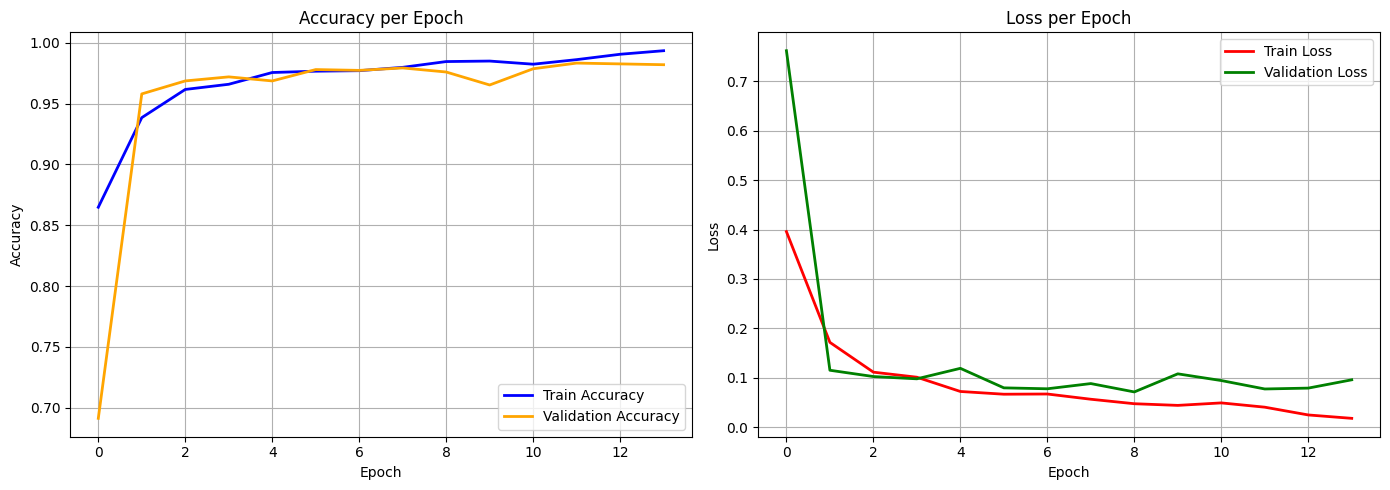

In [ ]:
# Accuracy Plot Testing Model
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linewidth=2)
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Confusion Matrix

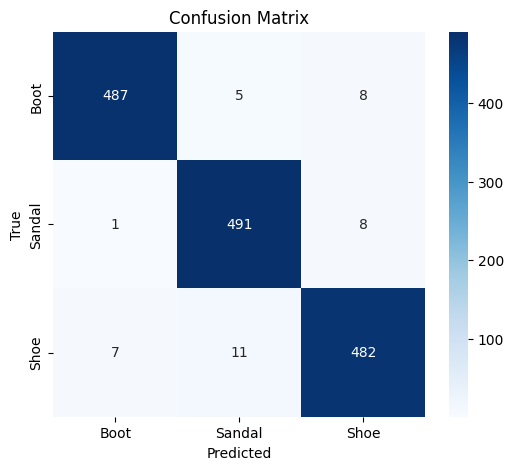


Classification Report:

              precision    recall  f1-score   support

        Boot       0.98      0.97      0.98       500
      Sandal       0.97      0.98      0.98       500
        Shoe       0.97      0.96      0.97       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [ ]:
y_pred = model.predict(test_gen, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix data testing
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

## **Konversi Model**

In [ ]:
print(type(model))

<class 'keras.src.models.sequential.Sequential'>


In [ ]:
# Menyiapkan direktori untuk menyimpan model
saved_model_dir = pathlib.Path("saved_model")
tflite_dir = pathlib.Path("tflite")
tfjs_dir = pathlib.Path("tfjs_model")

for d in [saved_model_dir, tflite_dir, tfjs_dir]:
  os.makedirs(d, exist_ok=True)

In [ ]:
# Simpan model dalam format save model
model.export(str(saved_model_dir))
print("SavedModel diekspor di:", saved_model_dir)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140077316531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077316534928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077316537232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077316524560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077316531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077316531664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077275775440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077275776592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077275775632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077275777552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140077275777360: Te

### Konversi TF-Lite

In [ ]:
# Simpan model .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_dir))
tflite_model = converter.convert()

tflite_path = tflite_dir / "model.tflite"
tflite_path.write_bytes(tflite_model)
print("TFLite model disimpan di:", tflite_path)

TFLite model disimpan di: tflite/model.tflite


In [ ]:
# Tambahkan file label.txt model
class_labels = list(train_gen.class_indices.keys())
label_file = tflite_dir / "label.txt"
with open(label_file, "w") as f:
    for label in class_labels:
        f.write(label + "\n")
print("Label file disimpan di:", label_file)

Label file disimpan di: tflite/label.txt


### Konversi TFJS

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

print("TensorFlow.js model disimpan di:", tfjs_dir)
print("\nSemua model sudah siap (SavedModel, TFLite, dan TFJS)!")

2025-11-06 16:22:35.054107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762446155.074875   24191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762446155.081130   24191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762446155.100328   24191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762446155.100353   24191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762446155.100359   24191 computation_placer.cc:177] computation placer alr

## **Inference (Optional)**

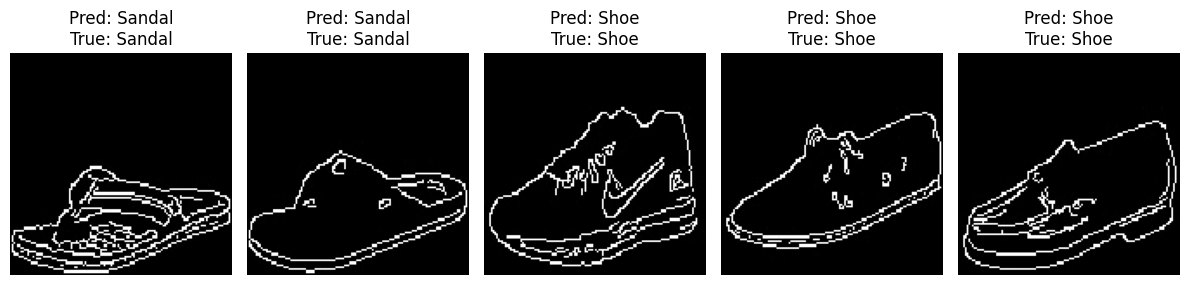

In [ ]:
tflite_path = "/content/tflite/model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi inference
def predict_tflite(image_array):
    # pastikan dtype sesuai
    input_data = np.expand_dims(image_array, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data), output_data

# Ambil data dari ImageGenerator yang sudah ada
x_test, y_test = next(iter(test_gen))
class_names = list(test_gen.class_indices.keys())

# Tampilkan beberapa gambar
plt.figure(figsize=(12, 6))
indices = random.sample(range(len(x_test)), 5)

for i, idx in enumerate(indices):
    img = x_test[idx]
    label_true = np.argmax(y_test[idx])

    pred_idx, probs = predict_tflite(img)
    pred_label = class_names[pred_idx]
    true_label = class_names[label_true]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis("off")
    plt.title(
        f"Pred: {pred_label}\nTrue: {true_label}"
    )

plt.tight_layout()
plt.show()

## **Requirements**

In [ ]:
notebook_folder = "/content/drive/MyDrive/Colab Notebooks/"

tmp_folder = "/content/temp_notebooks"
import os, shutil
os.makedirs(tmp_folder, exist_ok=True)

for f in os.listdir(notebook_folder):
    if f.endswith(".ipynb"):
        shutil.copy(os.path.join(notebook_folder, f), tmp_folder)

!pipreqs "{tmp_folder}" --force --scan-notebooks

from google.colab import files
files.download(f"{tmp_folder}/requirements.txt")

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download Folder**

In [ ]:
# Download folder model
folders_to_zip = [
    'saved_model',
    'tfjs_model',
    'tflite'
]

output_dir = "/content"

if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Memulai proses kompresi folder...")

for folder_name in folders_to_zip:
    if os.path.exists(folder_name) and os.path.isdir(folder_name):
        try:
            output_filename = os.path.join(output_dir, folder_name)
            shutil.make_archive(output_filename, 'zip', folder_name)

            print(f"✅ Berhasil membuat '{output_filename}.zip'")
        except Exception as e:
            print(f"Gagal membuat ZIP untuk folder '{folder_name}': {e}")
    else:
        print(f"Folder '{folder_name}' tidak ditemukan. Melewatkan.")

print("\nProses kompresi selesai.")

from google.colab import files
for folder_name in folders_to_zip:
    zip_file = f'{folder_name}.zip'
    if os.path.exists(zip_file):
        files.download(zip_file)

Memulai proses kompresi folder...
